In [33]:
!pip install -q -U 'tensorflow-text==2.8.*'
!pip install -q tf-models-official==2.7.0
!pip install tensorflow_addons
!pip install -U --no-cache-di gdown --pre

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:
from google.colab import drive
drive.mount('/content/drive')
!cp '/content/drive/My Drive/Dataset/demake_up_data.zip' '/content'
!unzip /content/demake_up_data.zip

Streaming output truncated to the last 5000 lines.
  inflating: demake_up_data/train/high_r/3785.png  
  inflating: demake_up_data/train/high_r/102.png  
  inflating: demake_up_data/train/high_r/3734.png  
  inflating: demake_up_data/train/high_r/327.png  
  inflating: demake_up_data/train/high_r/4183.png  
  inflating: demake_up_data/train/high_r/2335.png  
  inflating: demake_up_data/train/high_r/72.png  
  inflating: demake_up_data/train/high_r/1263.png  
  inflating: demake_up_data/train/high_r/3622.png  
  inflating: demake_up_data/train/high_r/273.png  
  inflating: demake_up_data/train/high_r/4442.png  
  inflating: demake_up_data/train/high_r/294.png  
  inflating: demake_up_data/train/high_r/173.png  
  inflating: demake_up_data/train/high_r/3872.png  
  inflating: demake_up_data/train/high_r/4123.png  
  inflating: demake_up_data/train/high_r/3619.png  
  inflating: demake_up_data/train/high_r/5.png  
  inflating: demake_up_data/train/high_r/3614.png  
  inflating: demake_up_

# Import neccessary libraries and configuration


In [35]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras as keras

from tensorflow.keras import layers
from tensorflow.keras.models import Model

In [36]:
# CONFIG PARAMETERS
BATCH_SIZE = 16
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
BUFFER_SIZE = BATCH_SIZE * 10
IMG_PATH = '/content/demake_up_data'
EPOCHS = 5

np.random.seed(69)

# Data processing

In [37]:
def load(img_file):
  makeup_img_file, non_img_file = tf.split(img_file, 2)

  makeup_img = tf.io.read_file(makeup_img_file[0])
  makeup_img = tf.image.decode_jpeg(makeup_img, channels=IMG_CHANNELS)

  non_img = tf.io.read_file(non_img_file[0])
  non_img = tf.image.decode_jpeg(non_img, channels=IMG_CHANNELS)

  makeup_img = tf.cast(makeup_img, tf.float32)
  non_img = tf.cast(non_img, tf.float32)

  return makeup_img, non_img

(224, 224, 3)
(224, 224, 3)


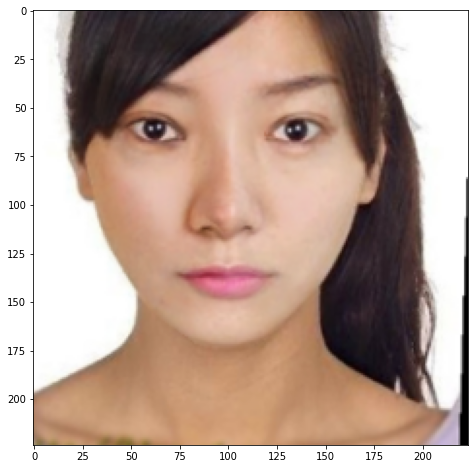

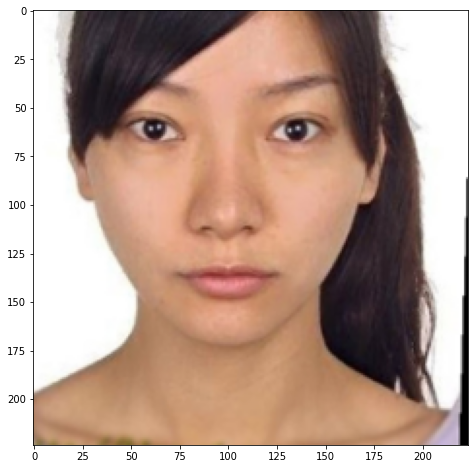

In [38]:
makeup_img, non_img = load([str(IMG_PATH+'/train/makeup/0.png'), 
                            str(IMG_PATH+'/train/non-makeup/0.png')])
print(makeup_img.shape)
print(non_img.shape)

plt.figure(figsize=(10, 8))
plt.imshow(makeup_img/255.0)

plt.figure(figsize=(10, 8))
plt.imshow(non_img/255.0)

In [44]:
@tf.function
def random_flip(makeup_img, non_img):
  if tf.random.uniform(()) > 0.5:
    # Random_mirroring
    makeup_img = tf.image.flip_left_right(makeup_img)
    non_img = tf.image.flip_left_right(non_img)
  return makeup_img, non_img

def processing_image(makeup_img, non_img):
  makeup_img = (makeup_img/255.0)
  non_img = (non_img/255.0)
  return makeup_img, non_img

def load_image_train(image_file):
  makeup_img, non_img = load(image_file)
  # makeup_img, non_img = random_flip(makeup_img, non_img)
  makeup_img, non_img = processing_image(makeup_img, non_img)
  return makeup_img, non_img

def load_image_val(image_file):
  makeup_img, non_img = load(image_file)
  makeup_img, non_img = processing_image(makeup_img, non_img)
  return makeup_img, non_img

In [40]:
def prepare_data(path):
  makeup_img_list = [os.path.join(path, f) for f in os.listdir(path)]
  data_list = [[i, i.replace('makeup', 'non-makeup')] for i in makeup_img_list]
  return data_list

train_data_list = prepare_data(str(IMG_PATH + '/train/makeup/'))
val_data_list = prepare_data(str(IMG_PATH + '/val/makeup/'))
test_data_list = prepare_data(str(IMG_PATH + '/test/makeup'))

np.random.shuffle(train_data_list)
np.random.shuffle(val_data_list)
np.random.shuffle(test_data_list)

In [45]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_data_list)
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)

train_datatset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)


val_dataset = tf.data.Dataset.from_tensor_slices(val_data_list)
val_dataset = val_dataset.map(load_image_val)
val_dataset = val_dataset.batch(BATCH_SIZE)


test_dataset = tf.data.Dataset.from_tensor_slices(test_data_list)
test_dataset = test_dataset.map(load_image_val)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Model Implementation

In [ ]:
class ResNetBlock():
    def __init__(self):
        pass

    def init_block(self, inputs):
        x = keras.layers.ZeroPadding2D(padding=3)(inputs)
        x = keras.layers.Conv2D(64, kernel_size=(7,7), strides=2)(x)
        x = tfa.layers.InstanceNormalization()(x)
        x = keras.layers.Activation('gelu')(x)
        return x

    def identity_block(self, inputs, n_filters):
        x = keras.layers.Conv2D(n_filters, kernel_size=(3, 3), padding='same', use_bias=False)(inputs)
        x = tfa.layers.InstanceNormalization()(x)
        x = keras.layers.Activation('gelu')(x)
        x = keras.layers.Conv2D(n_filters, kernel_size=(3, 3), padding='same', use_bias=False)(x)
        x = tfa.layers.InstanceNormalization()(x)
        skip_connection = keras.layers.Add()([inputs, x])
        x = keras.layers.Activation('relu')(skip_connection)
        return x

    def projection_block(self, inputs, filters, strides=2):
        x = keras.layers.Conv2D(filters=filters, kernel_size=(3, 3), padding='same', strides=strides, use_bias=False)(inputs)
        x = tfa.layers.InstanceNormalization()(x)
        x = keras.layers.Activation('gelu')(x)
        x = keras.layers.Conv2D(filters=filters, kernel_size=(3, 3), padding='same', use_bias=False)(x)
        x = tfa.layers.InstanceNormalization()(x)
        shortcut = keras.layers.Conv2D(filters=filters, kernel_size=(1, 1), padding='same', strides=strides, use_bias=False)(inputs)
        shortcut = tfa.layers.InstanceNormalization()(shortcut)
        skip_connection = keras.layers.Add()([shortcut, x])
        x = keras.layers.Activation('gelu')(skip_connection)
        return x

    def build_block(self, inputs, filters, n_iter, projection_block=False):
        layer = inputs
        if projection_block == True:
          layer = self.projection_block(layer, filters, strides=2)
        for iter in range(n_iter):
          layer = self.identity_block(layer, filters)
        return layer


In [ ]:
class Res34UNet():
    def __init__(self):
        self.res34 = ResNetBlock()
  
    def conv_block(self, inputs, num_filters):
      x = layers.Conv2D(filters=num_filters, kernel_size=(3,3), padding="same")(inputs)
      x = tfa.layers.InstanceNormalization()(x)
      x = layers.Activation('gelu')(x)
      return x

    def downsampling(self, inputs, n_filters, n_iter, projection_block=False):
      down = self.res34.build_block(inputs, n_filters, n_iter, projection_block)
      branch = keras.layers.Dropout(0.3)(down)
      return down, branch

    def upsampling(self, up_inputs, branch_inputs, n_filters):
        x_up = keras.layers.Conv2DTranspose(n_filters, kernel_size=(2, 2), padding='same', strides=2)(up_inputs)
        x = keras.layers.concatenate([x_up, branch_inputs])
        x = self.conv_block(x, n_filters)
        return x

    def build_model(self, input_shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)):
        # Inputs
        inputs = keras.layers.Input(shape=input_shape)

        # Encoder: ResNet34
        init_block = self.res34.init_block(inputs)
        pre_second_block = keras.layers.ZeroPadding2D(padding=1)(init_block)
        pre_second_block = keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2)(pre_second_block)
        down2, branch2 = self.downsampling(pre_second_block, 64, 3, False)
        down3, branch3 = self.downsampling(down2, 128, 4, True)
        down4, branch4 = self.downsampling(down3, 256, 6, True)
        
        # Bridge
        down5, branch5 = self.downsampling(down4, 512, 3, True)
        bridge = down5

        # Decoder
        up4 = self.upsampling(bridge, down4, 512)
        up3 = self.upsampling(up4, branch3, 256)
        up2 = self.upsampling(up3, branch2, 128)
        up1 = self.upsampling(up2, init_block, 64)
        init_branch = keras.layers.Conv2D(64, kernel_size=(1, 1), padding='same', strides=1)(inputs)
        up0 = self.upsampling(up1, init_branch, 64)

        # Output
        outputs = keras.layers.Conv2D(3, kernel_size=(1, 1), activation='sigmoid')(up0)
        model = Model(inputs=inputs, outputs=outputs)
        return model

In [ ]:
model = Res34UNet()
res34unet = model.build_model(input_shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
res34unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv2d_49 (Conv2D)             (None, 112, 112, 64  9472        ['zero_padding2d_2[0][0]']       
                                )                                                           

# Training

In [ ]:
def evaluate(model, epoch, dataset):
  psnr_non_mean = 0.0
  count = 0

  for makeup_img, non_img in dataset:
    pred_non = model([makeup_img], training=False)
    psnr_non = tf.image.psnr(pred_non, non_img, max_val=1.0)
    __psnr_non_mean = tf.math.reduce_mean(psnr_non)
    psnr_non_mean += __psnr_non_mean
    count += 1

  psnr_non_mean = psnr_non_mean/count
  print('---------->psnr_non: {}\n---------->epoch: {}\n---------->count:{}'
        .format(psnr_non_mean.numpy(), epoch, count))
  return psnr_non_mean

def generate_images(model, makeup_img, non_img):
  pred_non = model([makeup_img], training=False)
  plt.figure(figsize=(15, 20))

  display_list = [makeup_img[0], non_img[0], pred_non[0]]

  title = ['Input', 'Non-makeup', 'Predicted']
  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

In [ ]:
from official.nlp import optimization 

steps_per_epoch = tf.data.experimental.cardinality(train_dataset).numpy()
num_train_steps = steps_per_epoch * EPOCHS
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 1e-2
generator_optimizer = optimization.create_optimizer(
                      init_lr=init_lr,
                      num_train_steps=num_train_steps, 
                      num_warmup_steps=num_warmup_steps, 
                      optimizer_type='adamw'
)

In [ ]:
from tqdm import tqdm

@tf.function
def train_step(model, makeup_img, non_img):
  with tf.GradientTape() as tape:
    pred_non = model([makeup_img], training=True)
    loss = tf.reduce_mean(tf.square(pred_non-non_img))*100
  generator_gradients = tape.gradient(loss, model.trainable_variables)
  generator_optimizer.apply_gradients(zip(generator_gradients, model.trainable_variables))

  return loss

def fit(model, train_ds, epochs, val_ds):
    best_pnsr = 0.0
    step_counter = 0
    for epoch in range(epochs):
        # Train
        total_loss = 0.0
        for makeup_img, non_img in tqdm(train_ds):
            loss = train_step(model, makeup_img, non_img)
            total_loss = total_loss + loss
            step_counter += 1
        total_loss = total_loss/step_counter
        print('epoch: {}   loss: {}'.format(epoch, total_loss))
        
        pnsr = evaluate(model, epoch, val_ds)     
        if best_pnsr < pnsr:
            best_pnsr = pnsr
            
            for makeup_img, non_img in val_ds.take(1):
                generate_images(model, makeup_img, non_img)

100%|██████████| 313/313 [05:21<00:00,  1.03s/it]


epoch: 0   loss: 1.014242172241211
---------->psnr_non: 22.84776496887207
---------->epoch: 0
---------->count:32


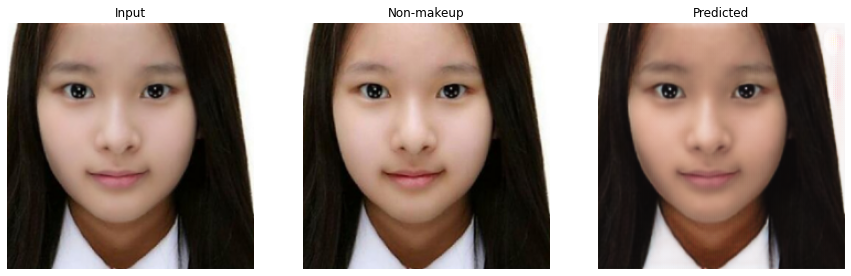

100%|██████████| 313/313 [04:20<00:00,  1.20it/s]


epoch: 1   loss: 0.27166756987571716
---------->psnr_non: 23.205650329589844
---------->epoch: 1
---------->count:32


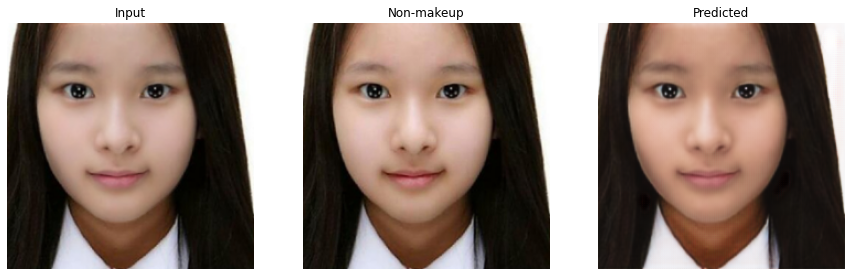

100%|██████████| 313/313 [04:22<00:00,  1.19it/s]


epoch: 2   loss: 0.1784786432981491
---------->psnr_non: 23.205650329589844
---------->epoch: 2
---------->count:32


100%|██████████| 313/313 [04:18<00:00,  1.21it/s]


epoch: 3   loss: 0.13389691710472107
---------->psnr_non: 23.205650329589844
---------->epoch: 3
---------->count:32


100%|██████████| 313/313 [04:21<00:00,  1.19it/s]


epoch: 4   loss: 0.10714811086654663
---------->psnr_non: 23.205650329589844
---------->epoch: 4
---------->count:32


In [46]:
tf.config.run_functions_eagerly(True)
fit(res34unet, train_dataset, EPOCHS, val_dataset)  